In [24]:
from load import loadcfg
from collections import OrderedDict
import numpy as np
import control
import matplotlib.pyplot as plt
from numpy.linalg import linalg

In [25]:
cfg = loadcfg("rocket.yaml")

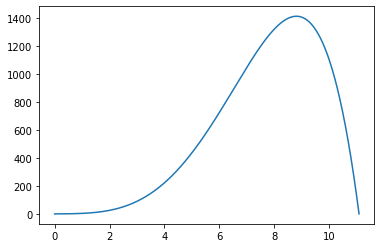

In [26]:
thrust = lambda a5, a4, a3, a2, a1, t:a5*(t**5) + a4*(t**4) + a3*t**3 +a2*t**2 +a1*t
acos = np.arccos
a =(-0.09, 0.9, 1,1,1)
THRUST = lambda t: thrust(*a, t)
t = np.linspace(0,11.099,1000)
plt.plot(t, thrust(*a, t))

<h1>State space:</h1><br>
    <X, Q, P, L><br>
        X -> R3<br>
        Q -> R4 -> (s, vx, vy, vz)<br>
        P -> R3<br>
        L -> R3<br>

<h2> state space derivatives </h2><br>
    <xdot, qdot, F, torque><br>
    xodt -> R3<br>
    qdot -> R3<br>
    F    -> R3<br>
    torque -> R3<br>


In [37]:
RotationMatrix = lambda s, vx, vy, vz:\
    np.array([
        [1-2*vy**2-2*vz**2, 2*vx*vy-2*s*vz, 2*vx*vz-2*vy],
        [2*vx*vy+2*s*vz, 1-2*vx**2-2*vz**2, 2*vy*vz-2*s*vx],
        [2*vx*vz-2*s*vy, 2*vy*vz+2*s*vx, 1-2*vx**2-2*vy**2]
    ])

def list_keys(cfg):
    k = ["YA0", "RA0", "PA0", "Ca", "Cn", "Cr"]
    for key in cfg.keys():
        if key in k:
            cfg[key] = np.array(cfg[key])
    return cfg

RollAxesUnit = lambda Q, REFA0: np.matmul(RotationMatrix(*Q),REFA0.T)
RAU = lambda R, REFA0: np.matmul(R, REFA0.T)
p = list_keys(cfg["properties"])
global p

unit = lambda x: x/linalg.norm(x)
p = cfg["properties"]
I0 = np.diag([p["Ixx"], p["Iyy"], p["Izz"]])
print(I0)
omega = lambda L, R: R @ I0 @ R.T @ L
sdot = lambda w, v: 0.5 * np.dot(w, v)
vdot = lambda w,v,s: 0.5*(s*w + np.cross(w,v))
AoA = lambda V, Ra: np.acos(np.dot(unit(V), Ra))
g = lambda Xx, Xy, Xz: p["Emass"]/(p["ER"]*Xz)**2
def windspeed_vec():
    return np.zeros(shape=(1,3))
Vcm = lambda Xdot: Xdot + windspeed_vec()
x_BAR = lambda: np.abs(p["Xcp"] - p["Xcm"]) #moment arm 
Linear_Velocity_Cp = lambda Ra, w: x_BAR()*np.sin(acos(np.dot(Ra, unit(w)))*(np.cross(Ra, w)))
v_apparent = lambda Xdot, Ra, w: Vcm(Xdot) + unit(Xdot)
mag = lambda x: linalg.norm(x)



Linear_Velocity_Cp(p["RA0"], [0,0,0])
print(p["RA0"])

[[50  0  0]
 [ 0 30  0]
 [ 0  0 40]]
[0 1 0]


In [38]:
def RocketModelDerivatives(t, y):
    P, L, Q, X = y
    R = RotationMatrix(*Q)
    print(R)
    YA = RAU(R, p["YA0"])
    RA = RAU(R, p["RA0"])
    print(RA)
    PA = RAU(R, p["PA0"])
    XDOT = P/p["mass"]
    w = omega(L, R)
    print(w)
    VDOT = vdot(w, XDOT, Q[0])
    SDOT = sdot(w, XDOT)
    QDOT = np.array([SDOT, *VDOT])
    FT = -THRUST(t)*RA
    FG = np.array([0,0,p["mass"]*g(*X)]).T
    FA_mag = 0.5*p["rho"]*mag(XDOT)*p["Arb"]*mag(p["Ca"]) #maybe not correct to mag CA
    FA = -FA_mag*RA
    FN_mag = 0.5*p["rho"]*mag(XDOT)*p["Arb"]*mag(p["Cn"])
    FN = FN_mag*np.cross(RA,np.cross(RA, Linear_Velocity_Cp(RA, w)))
    print(Linear_Velocity_Cp(RA, w))
    print(np.dot(RA, unit(w)))
    print(unit(w))
    print(np.cross(RA, unit(w)))
    F = FT + FG + FA + FN
    TN = FN_mag*x_BAR() * np.cross(RA, Linear_Velocity_Cp(RA, w))
    m = np.diag([1,1,0])
    #Tda = -p["Cda"] @ R @ m @ linalg.inv(R) @ w
    #TR_mag = 0.5*p["rho"]*
    torque = TN  #+ Tda
    return XDOT, QDOT, F, torque





In [36]:
q = np.array([10,30,2,90])
P = np.array([1,1,1])
L = np.array([1,1,1])
X = np.array([0,0,500])
RocketModelDerivatives(50, P, L, q, X)

[[-16207  -1680   5396]
 [  1920 -17999   -240]
 [  5360    960  -1807]]
[ -1680 -17999    960]
[ 310345618  628621438 1121358376]
[nan nan nan]
-8135.869261232937
[0.2346714  0.47533931 0.84792799]
[-15718.18165315   1649.8035667    3425.28043726]


(array([0.002, 0.002, 0.002]),
 array([ 2.06032543e+06, -5.96248295e+08,  9.96434555e+08, -8.35977340e+08]),
 array([nan, nan, nan]),
 array([nan, nan, nan]))

In [39]:
from scipy.integrate import odeint

In [42]:
r = integrate.ode(RocketModelDerivatives).set_integrator("dopri5")
y = [P, L, q, X]
r.set_initial_value(0, y)
r.integrate(1)

error: failed in processing argument list for call-back fcn.

array([0, 0, 0])